In [6]:
import pandas as pd
import numpy as np
import datetime
from prometheus_api_client import PrometheusConnect
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

PROMETHEUS_URL = "http://localhost:9090"
PROMETHEUS_ACCESS_TOKEN = ""

# Initialize Prometheus connection
prom = PrometheusConnect(url=PROMETHEUS_URL, disable_ssl=True)

# Example queries
ram_query = '100 - ((avg_over_time(node_memory_MemAvailable_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]) * 100) / avg_over_time(node_memory_MemTotal_bytes{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s]))'
cpu_query = '(sum by(instance) (irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints", mode!="idle"}[5m15s])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="172.16.101.106:9100",job="kubernetes-service-endpoints"}[5m15s])))) * 100'

In [9]:
def predict_and_evaluate(prom, query, name="value", start_days_ago=9, test_days=2):
    end_time = datetime.datetime.now()
    start_time = end_time - datetime.timedelta(days=start_days_ago)

    data = prom.custom_query_range(
        query=query, start_time=start_time, end_time=end_time, step="300"
    )

    if data:
        timestamps = [
            datetime.datetime.fromtimestamp(float(item[0]))
            for item in data[0]["values"]
        ]
        values = [float(item[1]) for item in data[0]["values"]]

        df = pd.DataFrame({"ds": timestamps, "y": values})

        # Split the dataset into training and testing based on date
        cutoff_date = df["ds"].max() - pd.Timedelta(days=test_days)
        train_df = df[df["ds"] <= cutoff_date]
        test_df = df[df["ds"] > cutoff_date]

        # Initialize and fit the Prophet model
        m = Prophet()
        m.fit(train_df)

        # Make future predictions for the test set duration
        future = m.make_future_dataframe(periods=test_days * 288, freq="5min")
        forecast = m.predict(future)

        # Filter forecast to the test set period
        forecast_test_period = forecast[forecast["ds"] > cutoff_date]

        # Calculate RMSE
        actual = test_df["y"].reset_index(drop=True)
        predicted = forecast_test_period["yhat"].reset_index(drop=True)
        rmse = sqrt(mean_squared_error(actual, predicted))

        print(f"RMSE for the test set: {rmse:.2f}")

        # Plot the forecast and actuals for test period
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(train_df["ds"], train_df["y"], label="Training Data")
        ax.plot(test_df["ds"], test_df["y"], label="Actual Test Data")
        ax.plot(
            forecast_test_period["ds"],
            forecast_test_period["yhat"],
            "g-",
            label="Forecasted Test Data",
        )
        ax.fill_between(
            forecast_test_period["ds"],
            forecast_test_period["yhat_lower"],
            forecast_test_period["yhat_upper"],
            color="g",
            alpha=0.2,
        )
        plt.title(f"{name} Forecast vs Actual")
        plt.ylabel(name)
        plt.xlabel("Date")
        plt.legend()
        plt.show()

    else:
        print("No data returned from Prometheus or unexpected data format.")

15:04:28 - cmdstanpy - INFO - Chain [1] start processing
15:04:29 - cmdstanpy - INFO - Chain [1] done processing


RMSE for the test set: 1.67


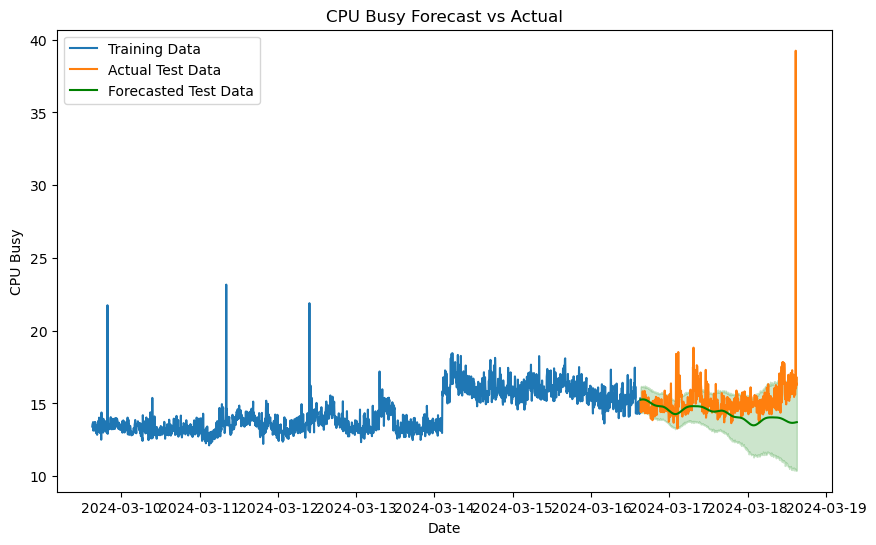

15:04:30 - cmdstanpy - INFO - Chain [1] start processing
15:04:31 - cmdstanpy - INFO - Chain [1] done processing


RMSE for the test set: 0.57


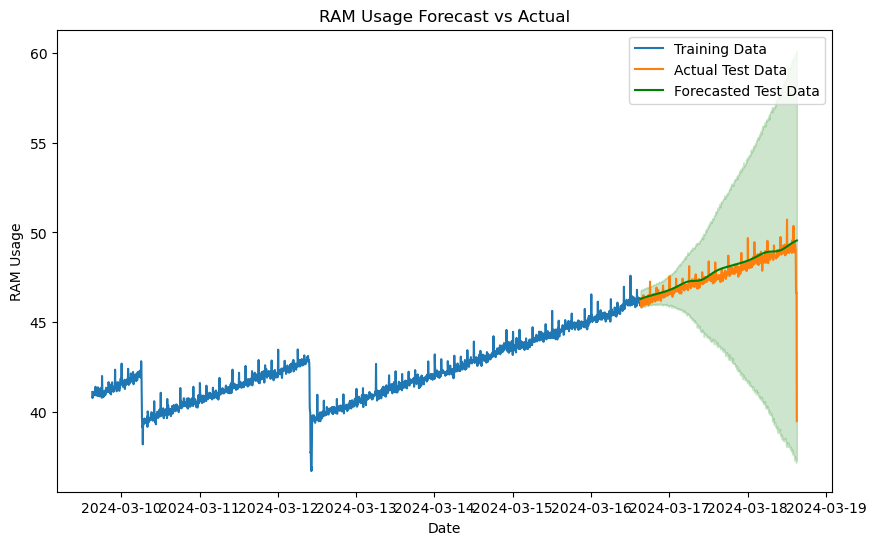

In [10]:
# Example usage
predict_and_evaluate(prom, cpu_query, name="CPU Busy", start_days_ago=9, test_days=2)
predict_and_evaluate(prom, ram_query, name="RAM Usage", start_days_ago=9, test_days=2)